In [4]:
import h5py, os, sys
from netCDF4 import Dataset
import numpy as np
import torch
from scipy.interpolate import interpn
from torch.autograd import Function
from scipy.sparse import coo_matrix, csr_matrix
from scipy.interpolate import interpn
import time

In [5]:
def compute_H(lat_idxs, lon_idxs, lat_delta, lon_delta, lat_grid, lon_grid):
    # lat_idxs, lon_idxs -> grid_space of obs
    # lat_delta, lon_delta -> grid_space difference
    # lat_grid = np.arange(-90,90,128)
    # lon_grid = np.arange(0,360,256)

    '''
    Computes the model grid interpolated onto the observation grid and returns result and the observation operator
    :param lat_idxs:
    :param lon_idxs:
    :param lat_delta:
    :param lon_delta:
    :return:
    '''
    # TODO double check this is correct
    lat_grid_delta = np.append(lat_grid[1:] - lat_grid[:-1], 90 - lat_grid[-1] + lat_grid[0] + 90) # [1.40625]*128
    lon_grid_delta = np.append(lon_grid[1:] - lon_grid[:-1], 360 - lon_grid[-1] + lon_grid[0]) # [1.40625]*256
    H = np.zeros((lat_idxs.size, 4, 2)) # (num_obs,4,2)
    H[:, 0, 0] = np.ravel_multi_index((lat_idxs, lon_idxs), (lat_grid.size, lon_grid.size)) # finds index of lat-lon pair in flattened (128,256) vector
    H[:, 1, 0] = np.ravel_multi_index(((lat_idxs + 1) % lat_grid.size, lon_idxs), (lat_grid.size, lon_grid.size))
    H[:, 2, 0] = np.ravel_multi_index((lat_idxs, (lon_idxs + 1) % lon_grid.size), (lat_grid.size, lon_grid.size))
    H[:, 3, 0] = np.ravel_multi_index(((lat_idxs + 1) % lat_grid.size, (lon_idxs + 1) % lon_grid.size),
                                      (lat_grid.size, lon_grid.size))
    denominator = 1. / (lat_grid_delta[lat_idxs] * lon_grid_delta[lon_idxs]) # 
    H[:, 0, 1] = denominator * (lat_grid_delta[lat_idxs] - lat_delta) * (lon_grid_delta[lon_idxs] - lon_delta) # H holds delta information for iterpolation
    H[:, 1, 1] = denominator * (lat_delta) * (lon_grid_delta[lon_idxs] - lon_delta)
    H[:, 2, 1] = denominator * (lat_grid_delta[lat_idxs] - lat_delta) * (lon_delta)
    H[:, 3, 1] = denominator * lat_delta * lon_delta
    return H.reshape(-1, 2)

In [6]:
lat = np.load('/eagle/MDClimSim/troyarcomano/1.40625deg_npz_40shards/lat.npy')
long = np.load('/eagle/MDClimSim/troyarcomano/1.40625deg_npz_40shards/lon.npy')
print('Using lats :',lat)
print('Using longs :',long)

def find_index_delta(x, y):
    # x (lat) (-90,90)
    # y (lon) (0,360)

    xi = np.searchsorted(lat, x, side='left') - 1 # lat -> x_idx
    delta_x = x - lat[xi]
    x_remove = xi == -1
    if np.any(x_remove):
        delta_x[xi == -1] = 180 + x[xi == -1] - lat[-1]
        xi[xi == -1] = len(lat) - 1
    yi = np.searchsorted(long, y, side='left') - 1 # lon -> y_idx
    delta_y = y - long[yi]
    y_remove = yi == -1
    if np.any(y_remove):
        delta_y[yi == -1] = 360 + y[yi == -1] - long[-1]
        yi[yi == -1] = len(long) - 1
    return xi, yi, delta_x, delta_y, x_remove, y_remove

Using lats : [-89.296875 -87.890625 -86.484375 -85.078125 -83.671875 -82.265625
 -80.859375 -79.453125 -78.046875 -76.640625 -75.234375 -73.828125
 -72.421875 -71.015625 -69.609375 -68.203125 -66.796875 -65.390625
 -63.984375 -62.578125 -61.171875 -59.765625 -58.359375 -56.953125
 -55.546875 -54.140625 -52.734375 -51.328125 -49.921875 -48.515625
 -47.109375 -45.703125 -44.296875 -42.890625 -41.484375 -40.078125
 -38.671875 -37.265625 -35.859375 -34.453125 -33.046875 -31.640625
 -30.234375 -28.828125 -27.421875 -26.015625 -24.609375 -23.203125
 -21.796875 -20.390625 -18.984375 -17.578125 -16.171875 -14.765625
 -13.359375 -11.953125 -10.546875  -9.140625  -7.734375  -6.328125
  -4.921875  -3.515625  -2.109375  -0.703125   0.703125   2.109375
   3.515625   4.921875   6.328125   7.734375   9.140625  10.546875
  11.953125  13.359375  14.765625  16.171875  17.578125  18.984375
  20.390625  21.796875  23.203125  24.609375  26.015625  27.421875
  28.828125  30.234375  31.640625  33.046875  34.

In [9]:
old_means = np.load('/eagle/MDClimSim/troyarcomano/1.40625deg_npz_40shards/normalize_mean.npz')
old_stds = np.load('/eagle/MDClimSim/troyarcomano/1.40625deg_npz_40shards/normalize_std.npz')

# Use new means and stds
means = np.load('/eagle/MDClimSim/tungnd/data/wb2/1.40625deg_from_full_res_1_step_6hr_h5df/normalize_mean.npz')
stds = np.load('/eagle/MDClimSim/tungnd/data/wb2/1.40625deg_from_full_res_1_step_6hr_h5df/normalize_std.npz')
print('\nUsing means :',means)
print('\nOld means :',old_means)
print('\nUsing stds :',stds)
print('\nOld stds :',old_stds)

dir = '/eagle/MDClimSim/awikner'
troy_dir = '/eagle/MDClimSim/troyarcomano/ml4dvar_climax_v2/'
matt_dir = '/eagle/MDClimSim/mjp5595/ml4dvar/obs/'

full_obs_file = 'irga_2014_2015_2020_all.hdf5'
msl_obs_file = 'irga_2014_2015_2020_msl_all.hdf5'
obs_file = 'igra_141520_stormer_obs_standardized_360_3.hdf5'
obs_file_raw = 'igra_141520_stormer_obs_standardized_360_3_raw.hdf5'

#if os.path.exists(os.path.join(matt_dir, obs_file)):
#    os.remove(os.path.join(matt_dir, obs_file))
f = h5py.File(os.path.join(dir, full_obs_file), 'r')
f_msl = h5py.File(os.path.join(dir, msl_obs_file), 'r')
#f_obs = h5py.File(os.path.join(matt_dir, obs_file), 'a')
#f_obs_raw = h5py.File(os.path.join(matt_dir, obs_file_raw), 'a')


Using means : <numpy.lib.npyio.NpzFile object at 0x7f6ad06c2b50>

Old means : <numpy.lib.npyio.NpzFile object at 0x7f6ad05e57f0>

Using stds : <numpy.lib.npyio.NpzFile object at 0x7f6b74a849d0>

Old stds : <numpy.lib.npyio.NpzFile object at 0x7f6ad06c2f10>


In [10]:
SOUNDING_TO_STORMER_pl = {'gph':'geopotential','q':'specific_humidity','temp':'temperature','uwind':'u_component_of_wind','vwind':'v_component_of_wind'}
SOUNDING_TO_STORMER_sl = {'surface_press':'mean_sea_level_pressure','surface_uwind':'10m_u_component_of_wind', 'surface_vwind':'10m_v_component_of_wind', 'surface_temp':'2m_temperature'}

modeled_vars = ['gph', 'uwind', 'vwind', 'temp', 'q']
mean_std_names = ['geopotential', 'u_component_of_wind', 'v_component_of_wind', 'temperature', 'specific_humidity']

modeled_surface_vars = ['surface_press', 'surface_uwind', 'surface_vwind', 'surface_temp']

pred_plevels = np.array([1000, 925, 850, 700, 600, 500, 400, 300, 250, 200, 150, 100, 50], dtype='f8')

In [12]:
print('f_keys() :',f['2014/01/01/00/'].keys())
print('f_msk_keys() :',f_msl['2014/01/01/00/'].keys())

f_keys() : <KeysViewHDF5 ['dpdp', 'gph', 'q', 'rh', 'surface_dpdp', 'surface_press', 'surface_q', 'surface_rh', 'surface_temp', 'surface_uwind', 'surface_vwind', 'temp', 'uwind', 'vwind']>
f_msk_keys() : <KeysViewHDF5 ['surface_press']>


In [19]:
sp = f['2014/01/01/12/surface_press'][:,3]
sp_msl = f_msl['2014/01/01/12/surface_press'][:,3]

print('sp.shape, min, mean, max :',sp.shape,np.min(sp),np.mean(sp),np.max(sp))
print('sp_msl.shape, min, mean, max :',sp_msl.shape,np.min(sp_msl),np.mean(sp_msl),np.max(sp_msl))

sp.shape, min, mean, max : (600,) 330.5559196292297 943.2858966081803 1142.298573570242
sp_msl.shape, min, mean, max : (592,) 973.8298933373367 1015.6057182564184 1068.442446946132


In [20]:
sp_msl = f_msl['2014/01/01/12/surface_press'][:,3]
print('sp_msl.shape, min, mean, max :',sp_msl.shape,np.min(sp_msl),np.mean(sp_msl),np.max(sp_msl))

sp_msl.shape, min, mean, max : (592,) 973.8298933373367 1015.6057182564184 1068.442446946132


In [ ]:
for year in list(f.keys()):
    #yr_grp = f_obs.create_group(year)
    for month in list(f[year].keys()):
        #mth_grp = f_obs[year].create_group(month)
        for day in list(f[year + '/' + month].keys()):
            #day_grp = f_obs[year + '/' + month].create_group(day)
            for hour in list(f[year + '/' + month + '/' + day].keys()):
                print(year + '/' + month + '/' + day + '/' + hour)
                #hr_group = f_obs[year + '/' + month + '/' + day].create_group(hour)
                for var_idx, var in enumerate(modeled_surface_vars):
                    #print('var_idx, var (0):',var_idx, var)

                    if var == 'surface_press':
                        try:
                            obs_data = f_msl[year + '/' + month + '/' + day + '/' + hour + '/' + var][:]
                        except:
                            continue
                    else:
                        try:
                            obs_data = f[year + '/' + month + '/' + day + '/' + hour + '/' + var][:]
                        except:
                            continue
                    obs_data = f[year + '/' + month + '/' + day + '/' + hour + '/' + var][:] # (n_obs, 4) -> (605, 4)
                    var_mean = means[f'{SOUNDING_TO_STORMER_sl[var]}'][0]
                    var_std = stds[f'{SOUNDING_TO_STORMER_sl[var]}'][0]

                    #try:
                    #    old_var_mean = old_means['%s' % (surface_vars_dict[var])][0]
                    #    old_var_std = old_stds['%s' % (surface_vars_dict[var])][0]
                    #    print('var, old_var_mean, new_var_mean :',var, old_var_mean,var_mean)
                    #    print('var, old_var_std, new_var_std :',var, old_var_std,var_std)
                    #except:
                    #    print('var, new_var_mean :',var, var_mean)
                    #    print('var, new_var_std :',var, var_std)

                    plevel_data = obs_data[:,[0,1,3]]
                    #plevel_data = plevel_data[np.lexsort((plevel_data[:, 1], plevel_data[:, 0]))]
                    #lat_obs = plevel_data[:, 0]
                    #long_obs = plevel_data[:, 1]
                    long_obs = (plevel_data[:, 1] + 360) % 360
                    plevel_data[:,1] = long_obs
                    plevel_data = plevel_data[np.lexsort((plevel_data[:, 1], plevel_data[:, 0]))]
                    lat_obs = plevel_data[:, 0]
                    long_obs = plevel_data[:,1]

                    #print('\tlong_obs (min/max):',min(long_obs),max(long_obs))
                    xi, yi, delta_x, delta_y, x_remove, y_remove = find_index_delta(lat_obs, long_obs)
                    red_idxs = (np.logical_not(x_remove)) & (np.logical_not(y_remove)) & \
                                (xi != len(lat) - 1) & (yi != len(long) - 1)
                    plevel_data = plevel_data[red_idxs] # (n_obs, 3) -> (604,3)
                    delta_x = delta_x[red_idxs]
                    delta_y = delta_y[red_idxs]
                    xi_red = xi[red_idxs]
                    yi_red = yi[red_idxs]
                    plevel_dataset = f_obs[year + '/' + month + '/' + day + '/' + hour].create_dataset(
                        '%s' % (f'{SOUNDING_TO_STORMER_sl[var]}'), data=plevel_data, dtype = 'f8'
                    )
                    plevel_dataset[:, :2] = plevel_data[:, :2]

                    #############################################################################################
                    #############################################################################################
                    # TODO should this be x100 here? Need to check final values
                    if var == 'surface_press':
                        plevel_dataset[:, 2] = (plevel_data[:, 2]*100 - var_mean)/var_std
                    elif var == 'surface_temp':
                        plevel_dataset[:, 2] = (plevel_data[:, 2] + 273.15 - var_mean) / var_std
                    else:
                        plevel_dataset[:, 2] = (plevel_data[:, 2] - var_mean) / var_std
                    plevel_dataset.attrs['mean'] = var_mean
                    plevel_dataset.attrs['std'] = var_std

                    H = compute_H(xi_red, yi_red, delta_x, delta_y, lat, long)
                    H_var_data = f_obs[year + '/' + month + '/' + day + '/' + hour].create_dataset(
                        '%s_H' % (f'{SOUNDING_TO_STORMER_sl[var]}'), H.shape, dtype = 'f8'
                    )
                    H_var_data[:] = H
                    #############################################################################################
                    #############################################################################################

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

background_error_covariance = np.load('/eagle/MDClimSim/mjp5595/ml4dvar/stormer/background_24hr_diff_hf_var_stormer_standardized_128_uv.npy')

In [2]:
background_error_covariance.shape

(69, 128, 256)

/tmp/ipykernel_129421/1797221176.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


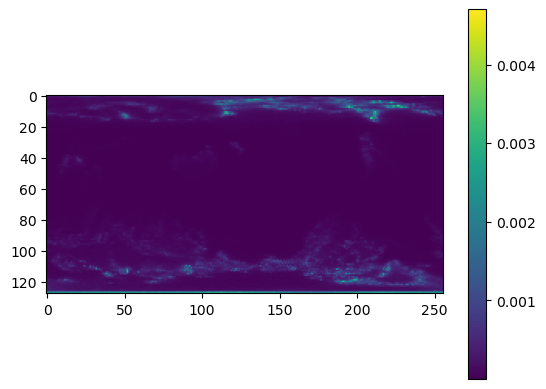

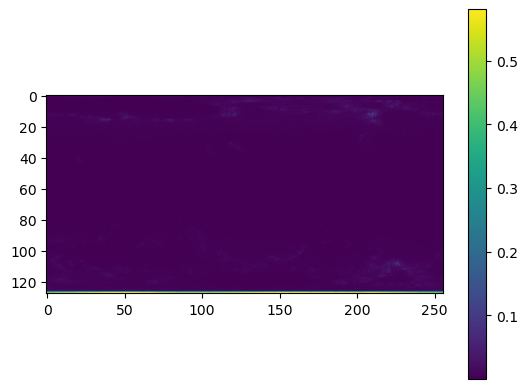

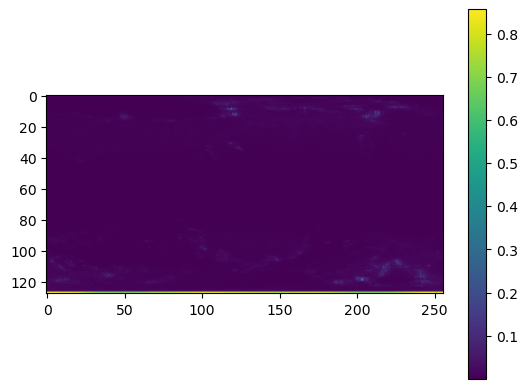

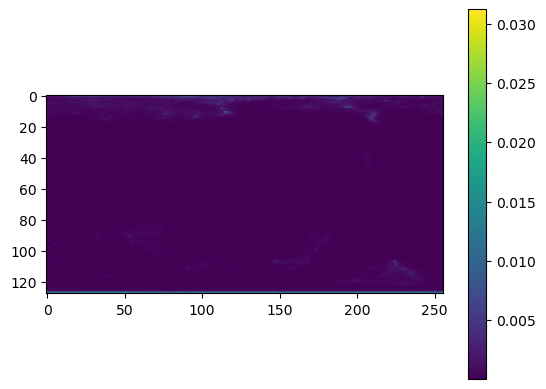

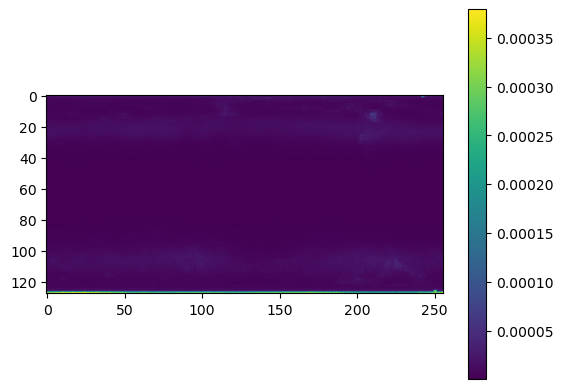

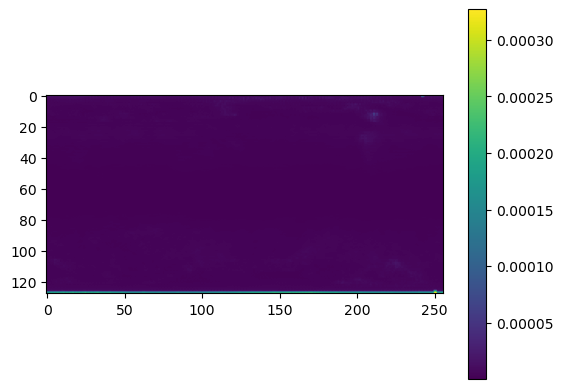

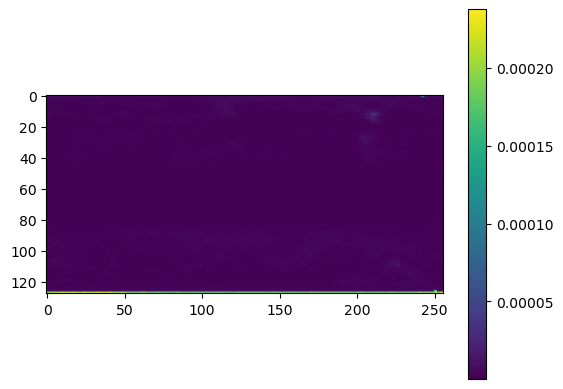

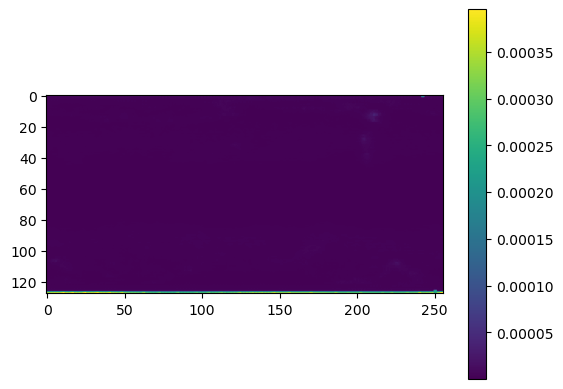

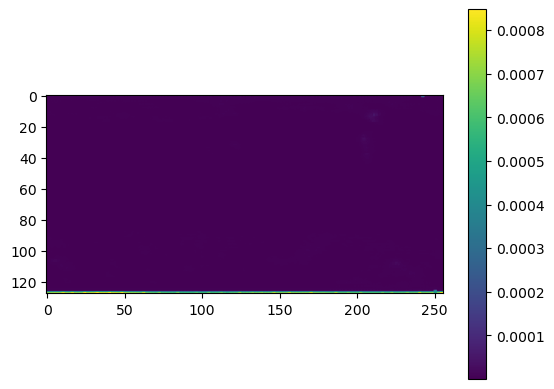

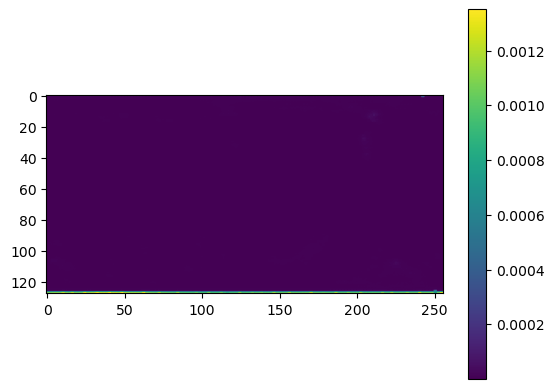

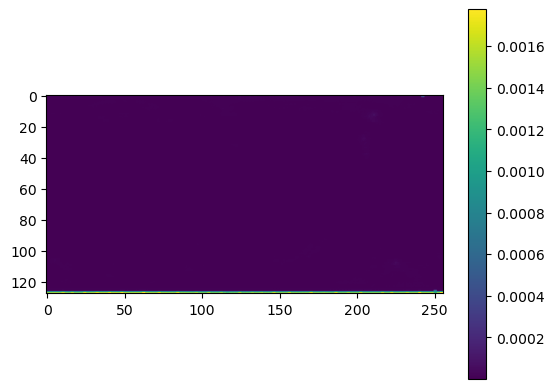

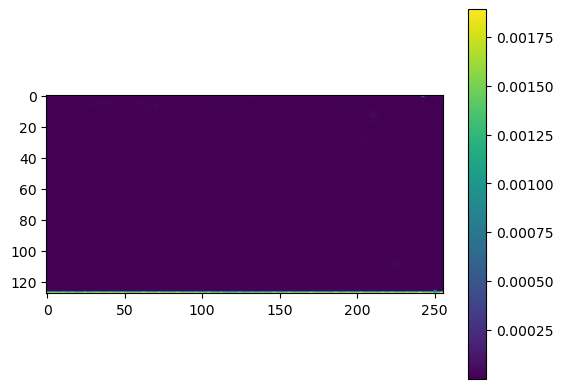

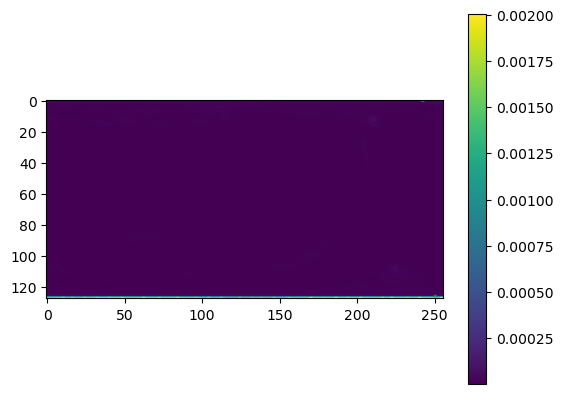

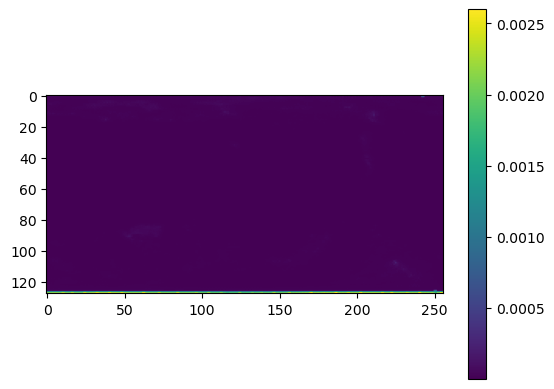

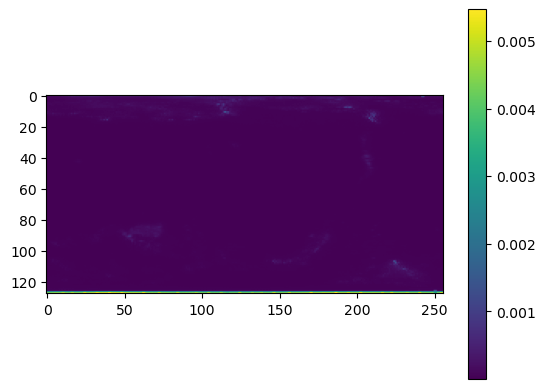

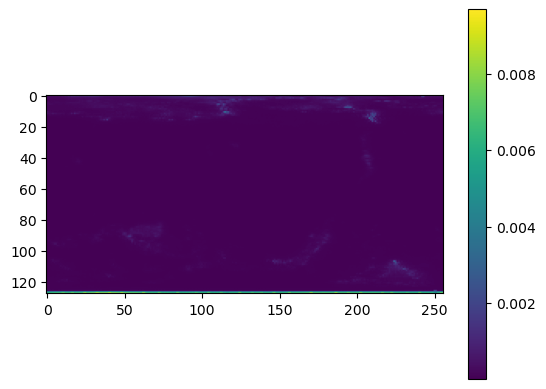

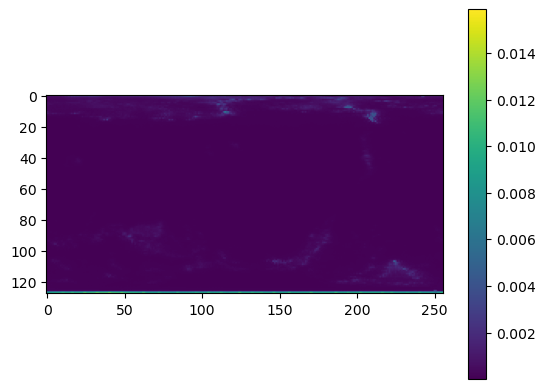

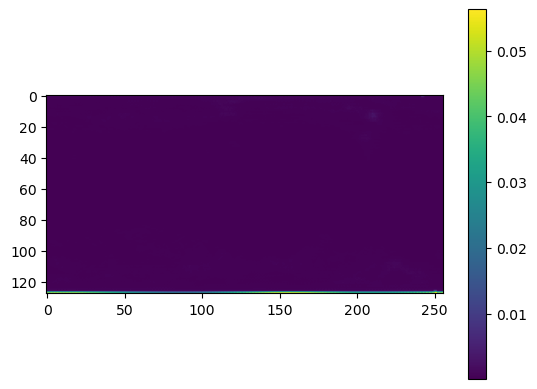

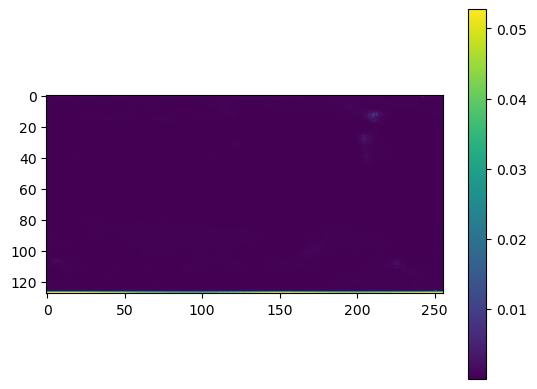

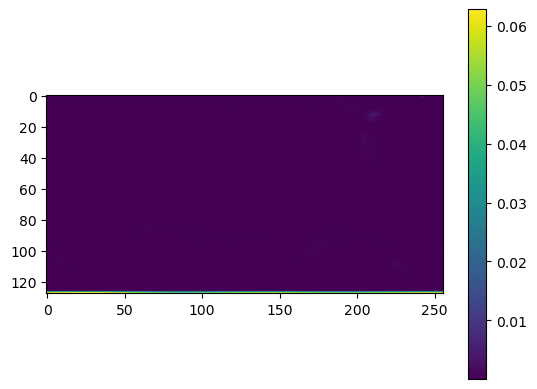

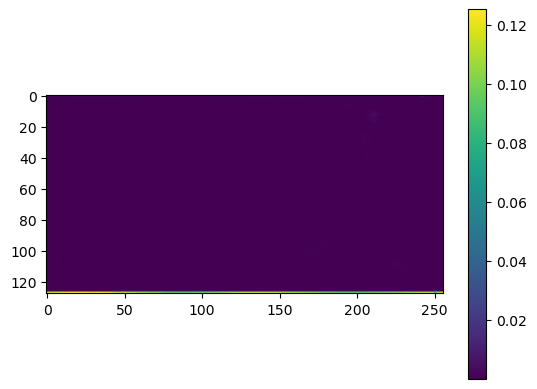

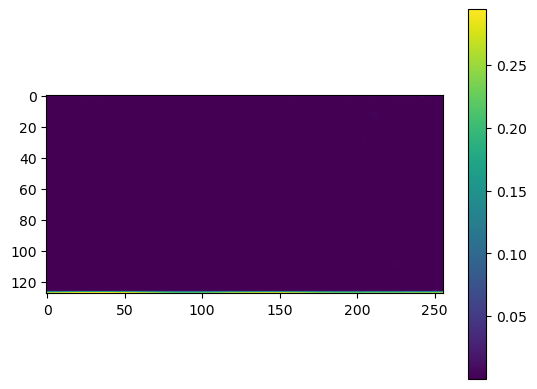

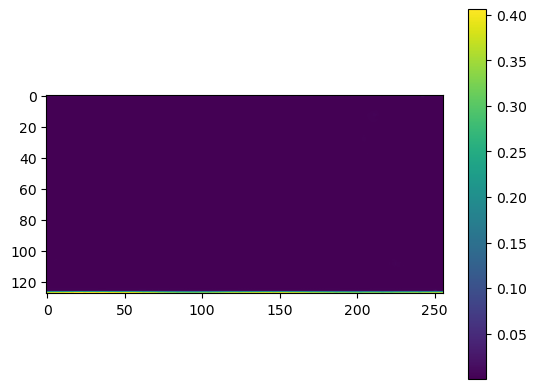

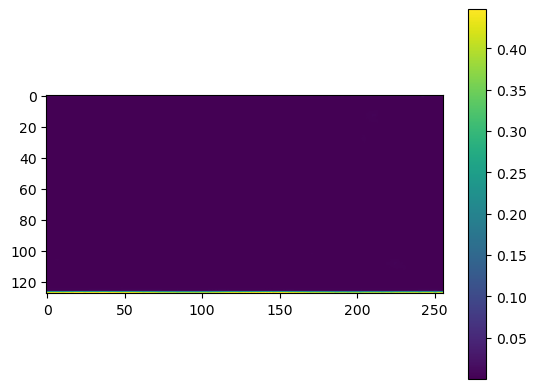

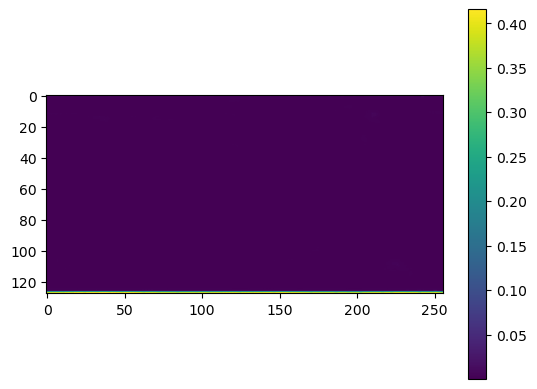

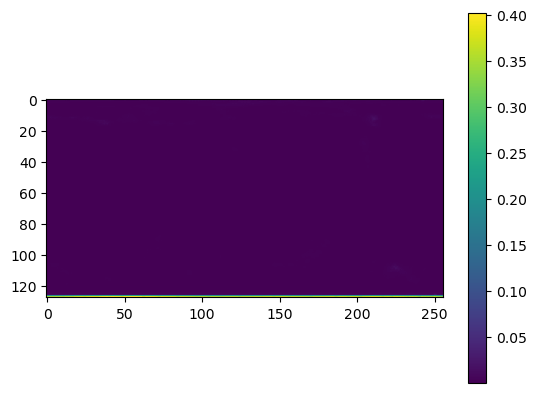

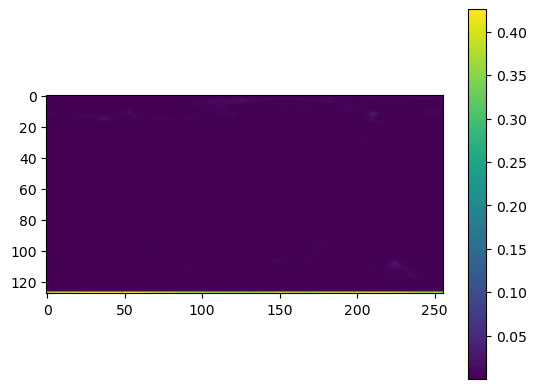

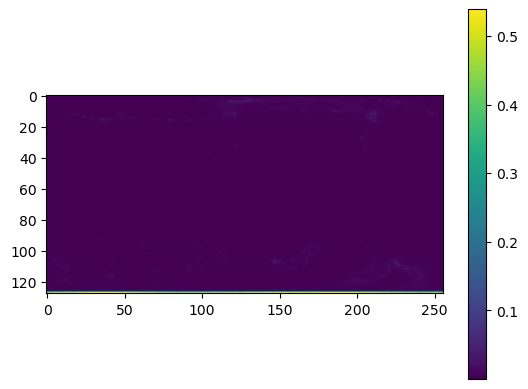

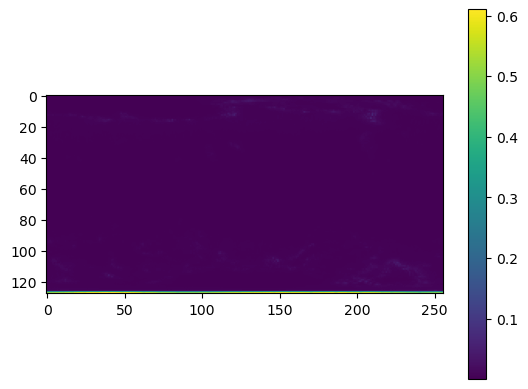

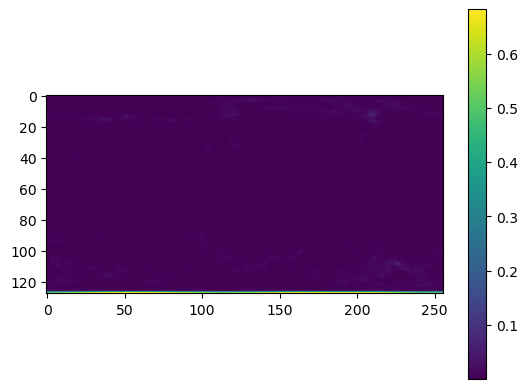

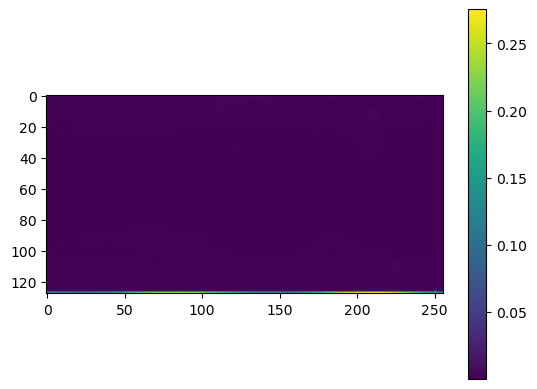

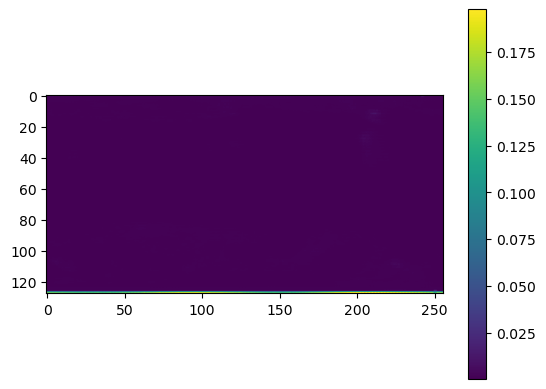

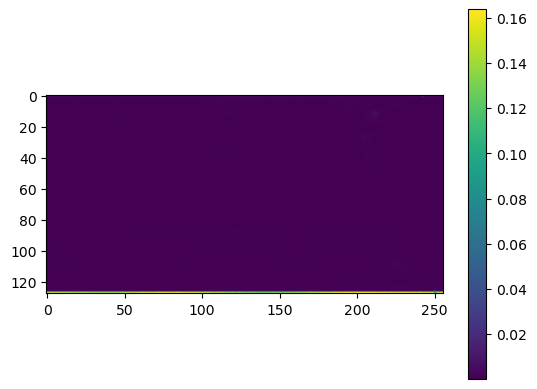

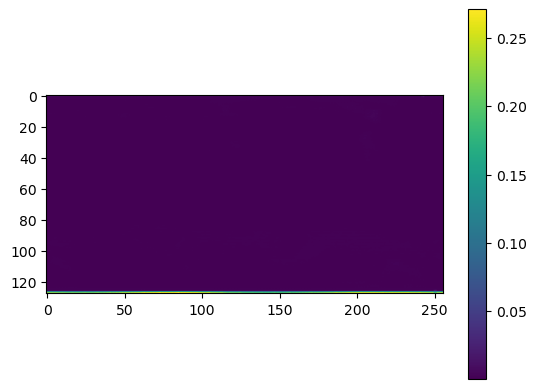

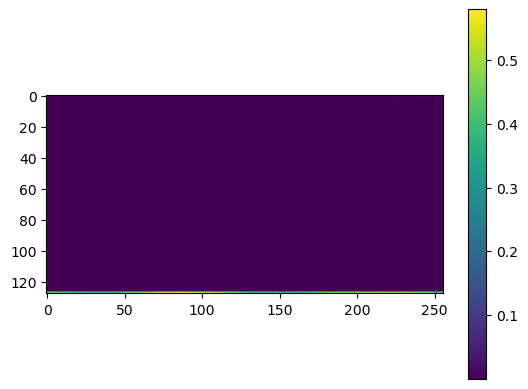

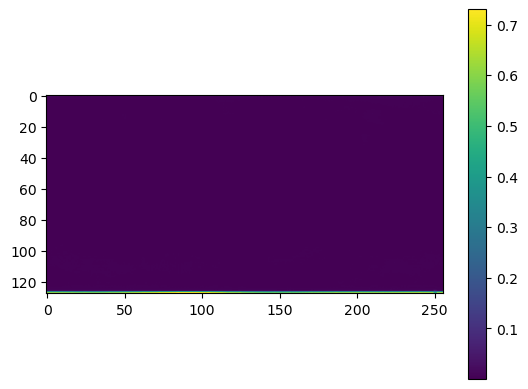

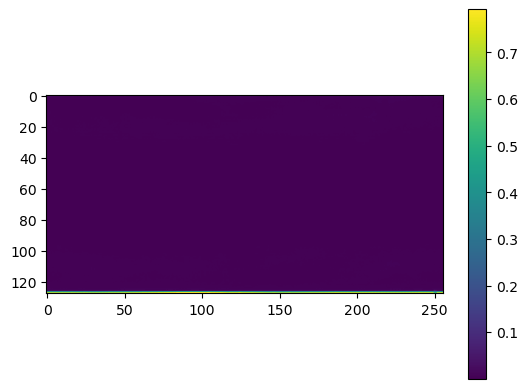

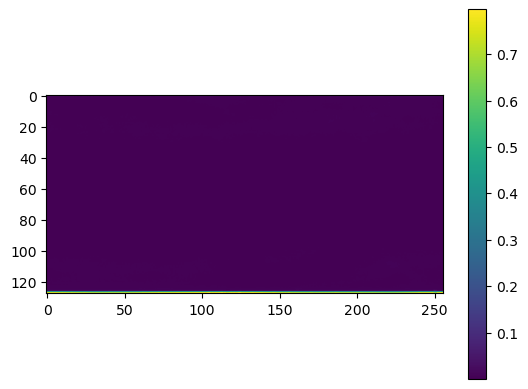

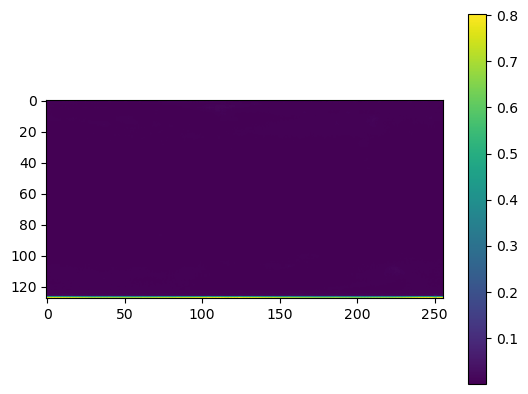

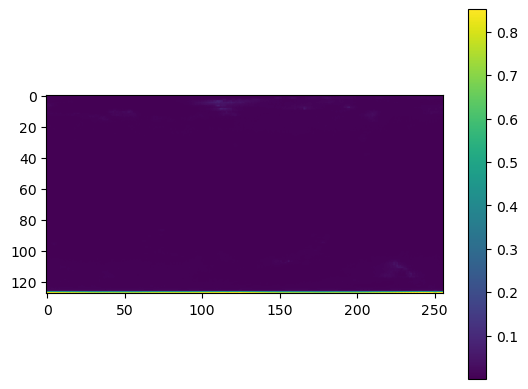

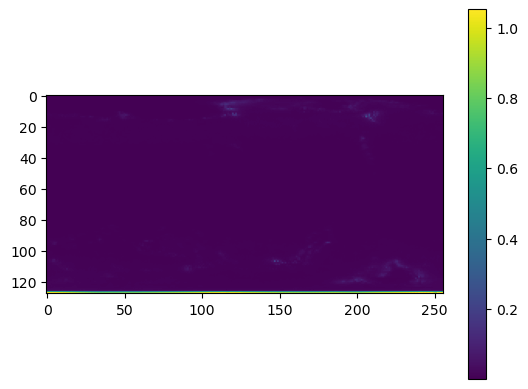

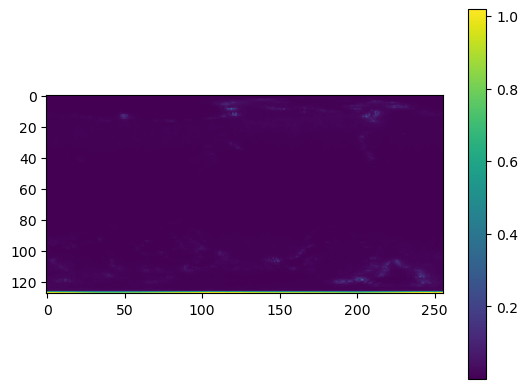

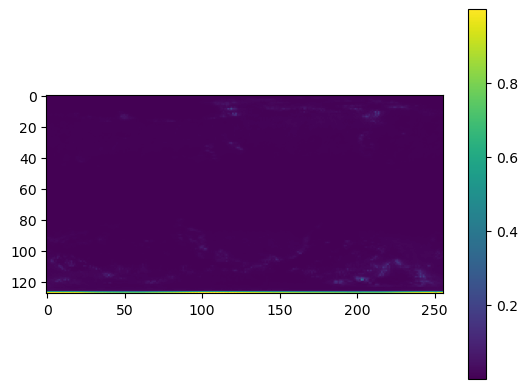

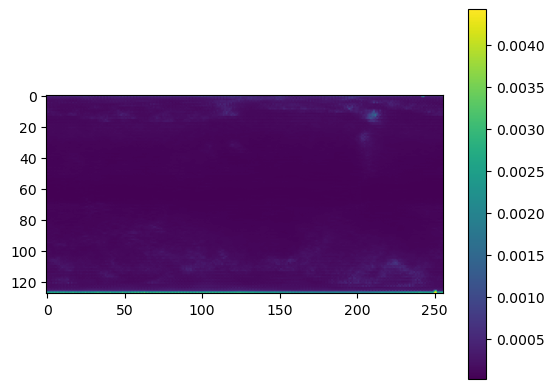

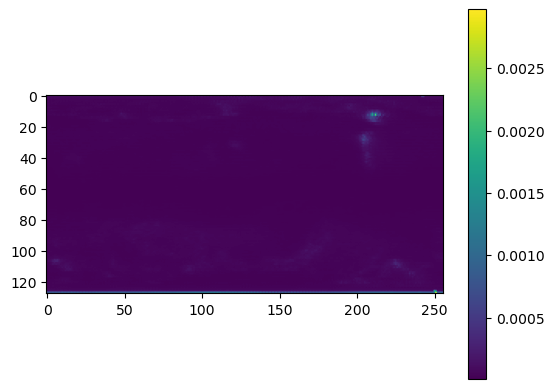

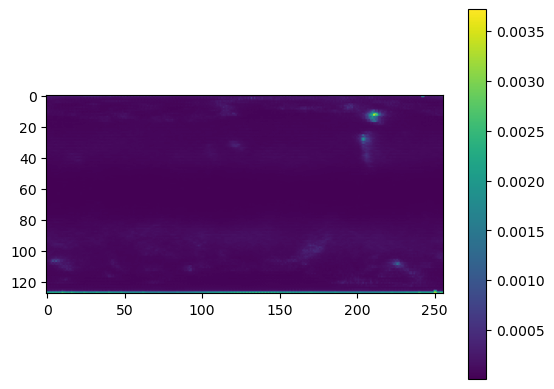

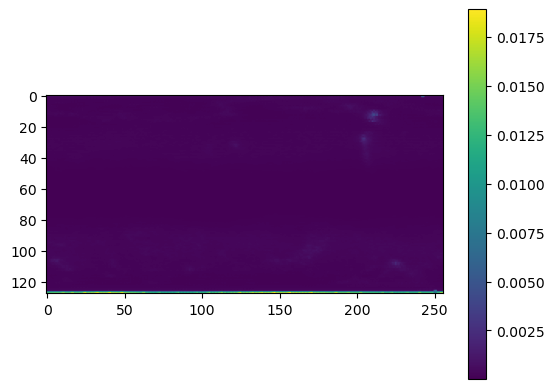

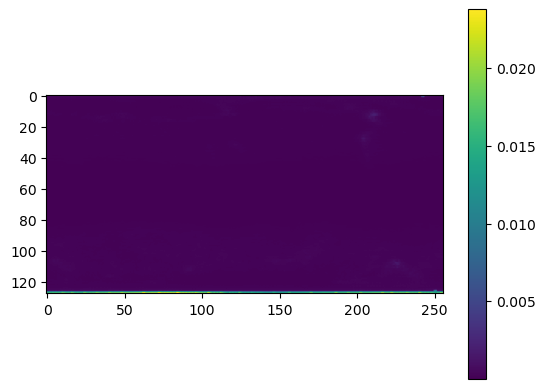

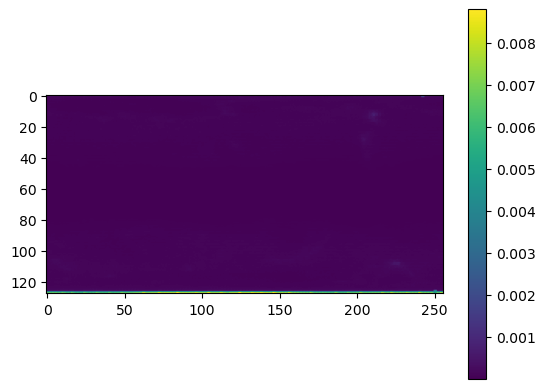

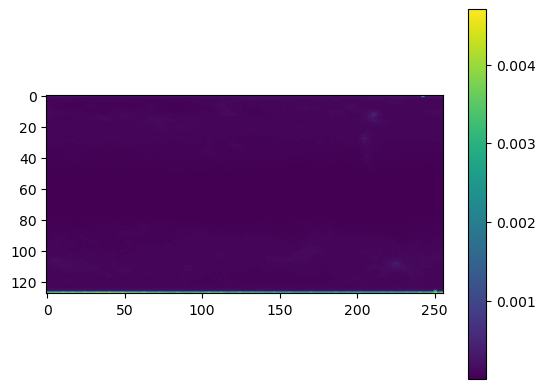

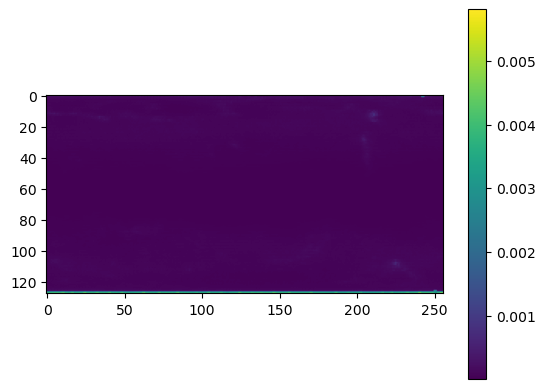

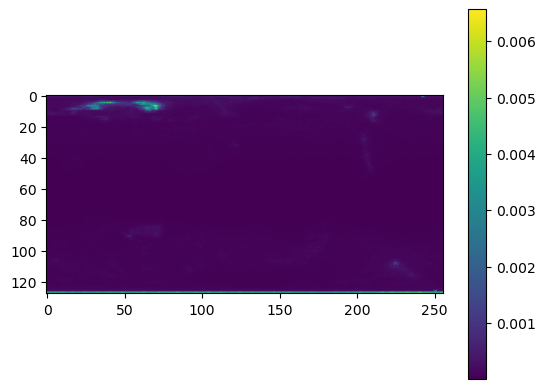

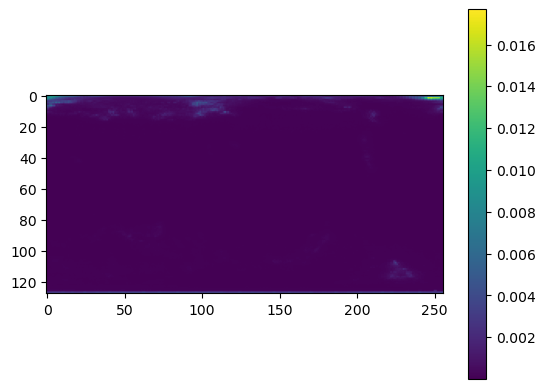

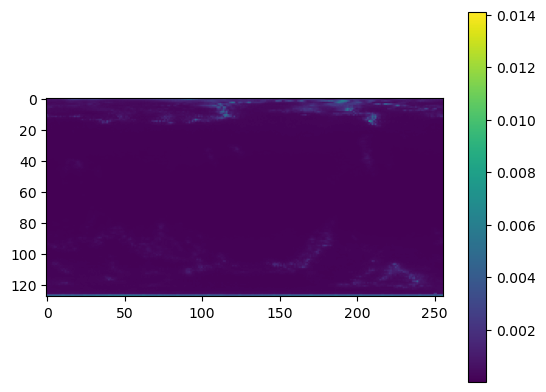

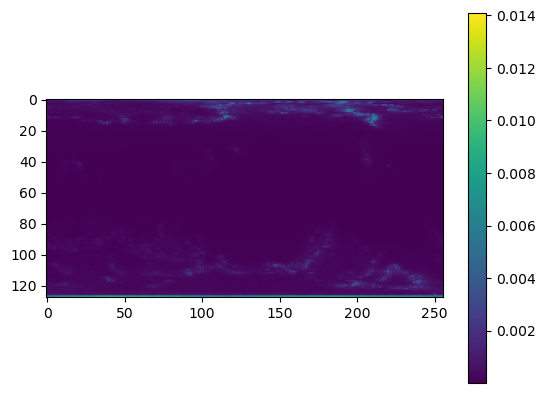

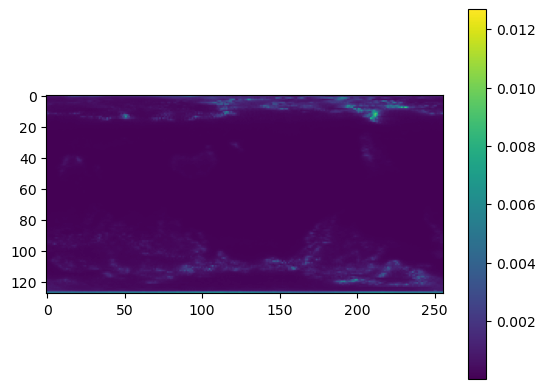

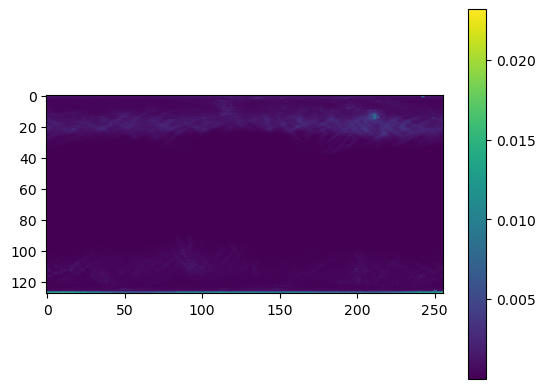

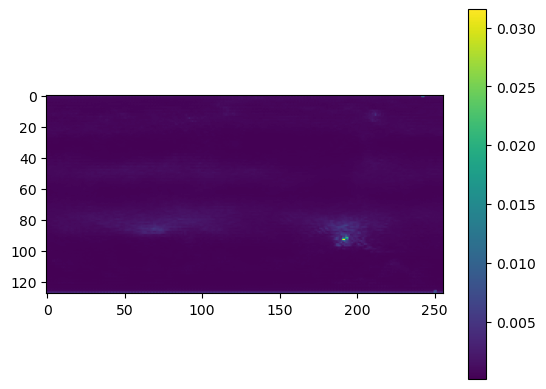

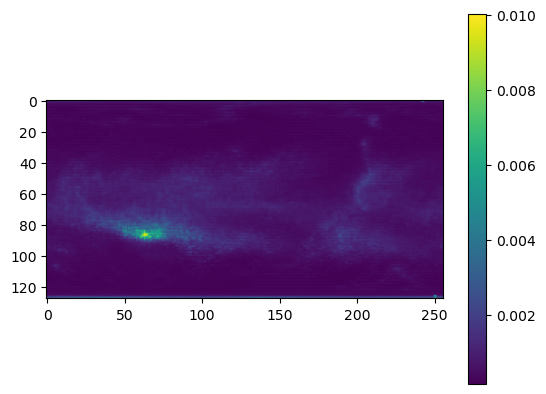

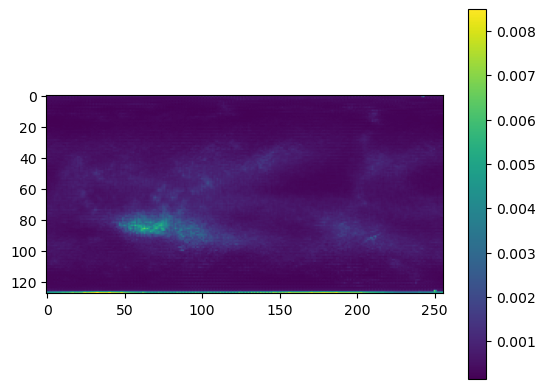

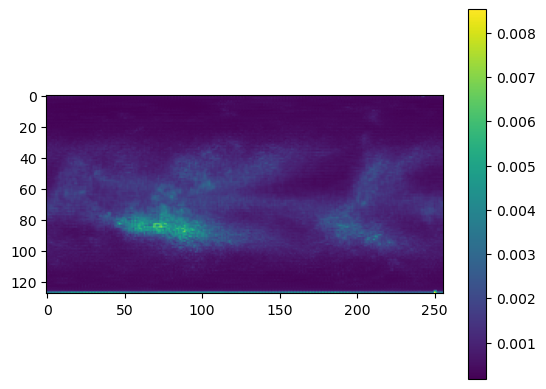

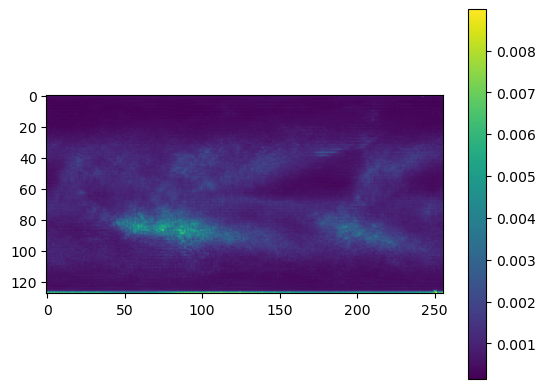

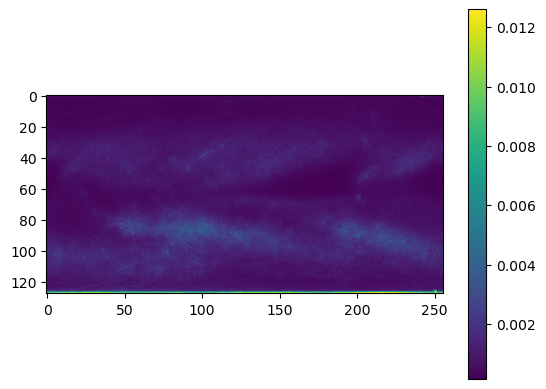

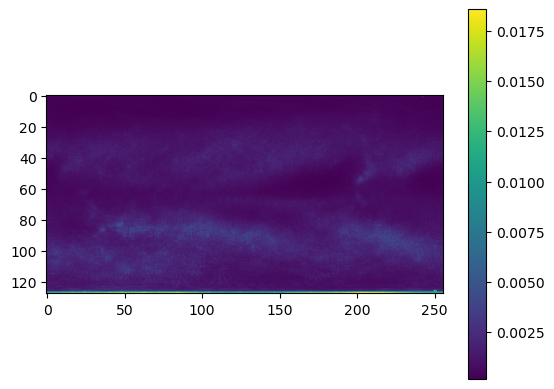

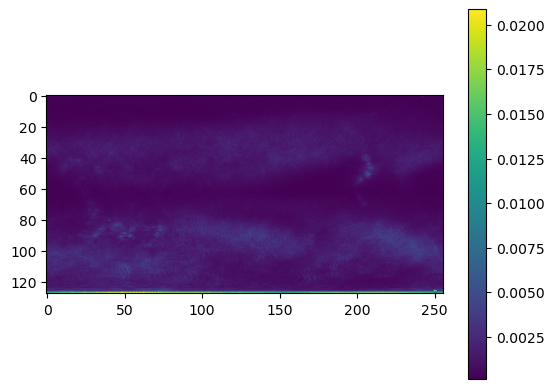

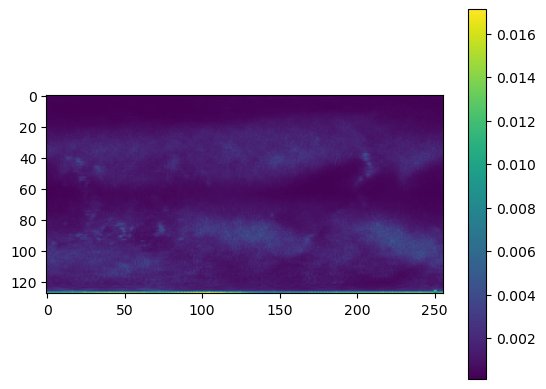

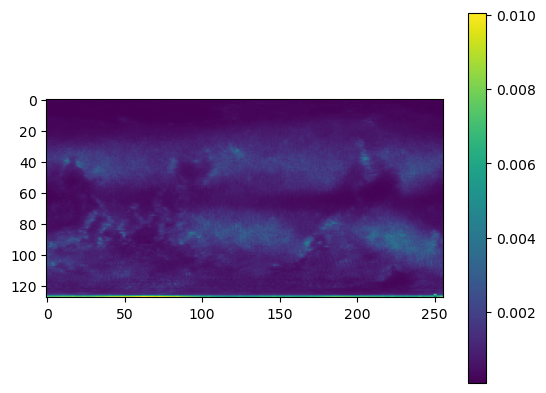

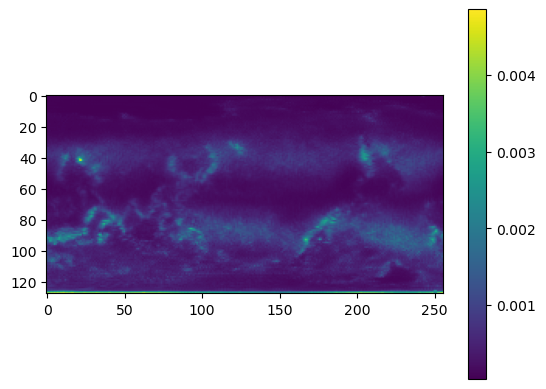

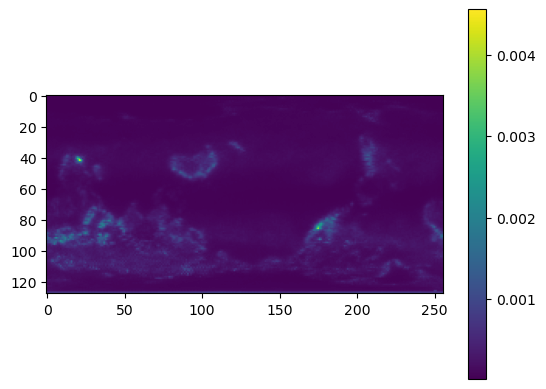

In [5]:
for i in range(len(background_error_covariance)):
    plt.figure()
    plt.imshow(background_error_covariance[i])
    plt.colorbar()